### Notebook for optimal initial sampling for material composition -> properties problem. 4 dimensions

written by Christina Schenk

last updated on 09/01/2025

tested on Christina's M1 Mac

#### import python packages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
import lhsmdu
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import csv
import sys
sys.path.append("../../../CASTRO/src")
from plot import *
from conditionedSampling import *
from utils import *

### Setting up a Single-Task GP Autonomous Data Acquisition Run

##### Specify the design space: lower and upper bounds for x and y, number of points at which we want to predict

In [2]:
#Lower and upper bounds for x and y:
#polymer:
PA56_lb = 0.8
PA56_ub = 1.0
#phytic acid:
PhA_lb = 0.0
PhA_ub = 0.05
#amino-based acids:
am_lb1 = 0.0
am_ub1 = 0.1
am_lb2 = 0.0
am_ub2 = 0.1
am_lb3 = 0.0
am_ub3 = 0.1
am_lb4 = 0.0
am_ub4 = 0.1
#metallic-based acids:
met_lb1 = 0.0
met_ub1 = 0.14
met_lb2 = 0.0
met_ub2 = 0.14
met_lb3 = 0.0
met_ub3 = 0.14


#dimension of design space:
dim = 9

x1_lb = PA56_lb
x1_ub = PA56_ub

x2_lb = PhA_lb
x2_ub = PhA_ub

x3_lb = am_lb1
x3_ub = am_ub1

x4_lb = am_lb2
x4_ub = am_ub2

x5_lb = am_lb3
x5_ub = am_ub3

x6_lb = am_lb4
x6_ub = am_ub4

x7_lb = met_lb1
x7_ub = met_ub1

x8_lb = met_lb2
x8_ub = met_ub2

x9_lb = met_lb3
x9_ub = met_ub3

bounds = [[x1_lb,x1_ub], [x2_lb,x2_ub], [x3_lb,x3_ub], [x4_lb,x4_ub], [x5_lb,x5_ub], [x6_lb,x6_ub], [x7_lb,x7_ub], [x8_lb,x8_ub], [x9_lb,x9_ub]]

#### Latin Hypercube sampling on domain with variables summing up to 1: Sequentially and infeasible ones rejected/removed from sample set: 

In [3]:
import numpy as np
from scipy.stats import qmc

# Define the number of samples and the number of dimensions
n_samp = 90  # Adjust as needed
n_dim = 9     # 9 dimensions
seeds = [42, 123, 7, 99, 56]  # List of random seeds


# Function to normalize the samples
def normalize(samples):
    return samples / samples.sum(axis=1, keepdims=True)

# Function to scale the normalized samples while maintaining the sum constraint
def scale_and_renormalize(samples, bounds):
    scaled_samples = np.zeros_like(samples)
    for i, (lb, ub) in enumerate(bounds):
        scaled_samples[:, i] = lb + samples[:, i] * (ub - lb)
    # After scaling, renormalize to ensure the sum is exactly 1
    return scaled_samples / scaled_samples.sum(axis=1, keepdims=True)

# List to store the scaled samples from each seed
all_scaled_samples = []

# Generate samples for each seed
for seed in seeds:
    # Step 1: Create Latin Hypercube sampler with the current seed
    sampler = qmc.LatinHypercube(d=n_dim, seed=seed)
    
    # Step 2: Generate Latin Hypercube samples
    samples = sampler.random(n=n_samp)
    
    # Step 3: Normalize the samples
    samples_normalized = normalize(samples)
    
    # Step 4: Scale and renormalize the samples
    scaled_samples = scale_and_renormalize(samples_normalized, bounds)
    
    # Store the scaled samples
    all_scaled_samples.append(scaled_samples)

# Stack all the samples along a new axis (shape: num_seeds x n_samp x n_dim)
all_scaled_samples = np.stack(all_scaled_samples, axis=0)

# Compute the mean and standard deviation across the seeds (axis=0)
mean_samples = np.mean(all_scaled_samples, axis=0)
std_samples = np.std(all_scaled_samples, axis=0)

# Verify the shapes of the results
print(f"\nShape of mean samples: {mean_samples.shape}")
print(f"Shape of std samples: {std_samples.shape}")

# Print the mean and standard deviation of the first 5 samples
print("\nMean of the first 5 samples:")
print(mean_samples[:5])


Shape of mean samples: (90, 9)
Shape of std samples: (90, 9)

Mean of the first 5 samples:
[[0.8928819  0.00708992 0.00989916 0.01393019 0.01483669 0.00755734
  0.01486296 0.01668042 0.02226142]
 [0.89901252 0.00577627 0.01275193 0.0076685  0.01175614 0.00775312
  0.02113812 0.02161255 0.01253085]
 [0.89372813 0.00654742 0.01242996 0.01071533 0.00948461 0.01176835
  0.01398259 0.01984385 0.02149977]
 [0.90593598 0.00862241 0.00895605 0.00617207 0.01930274 0.01347912
  0.01609681 0.00679291 0.0146419 ]
 [0.89438258 0.00713822 0.02116423 0.01522317 0.00935817 0.00948484
  0.01726057 0.00749739 0.01849084]]


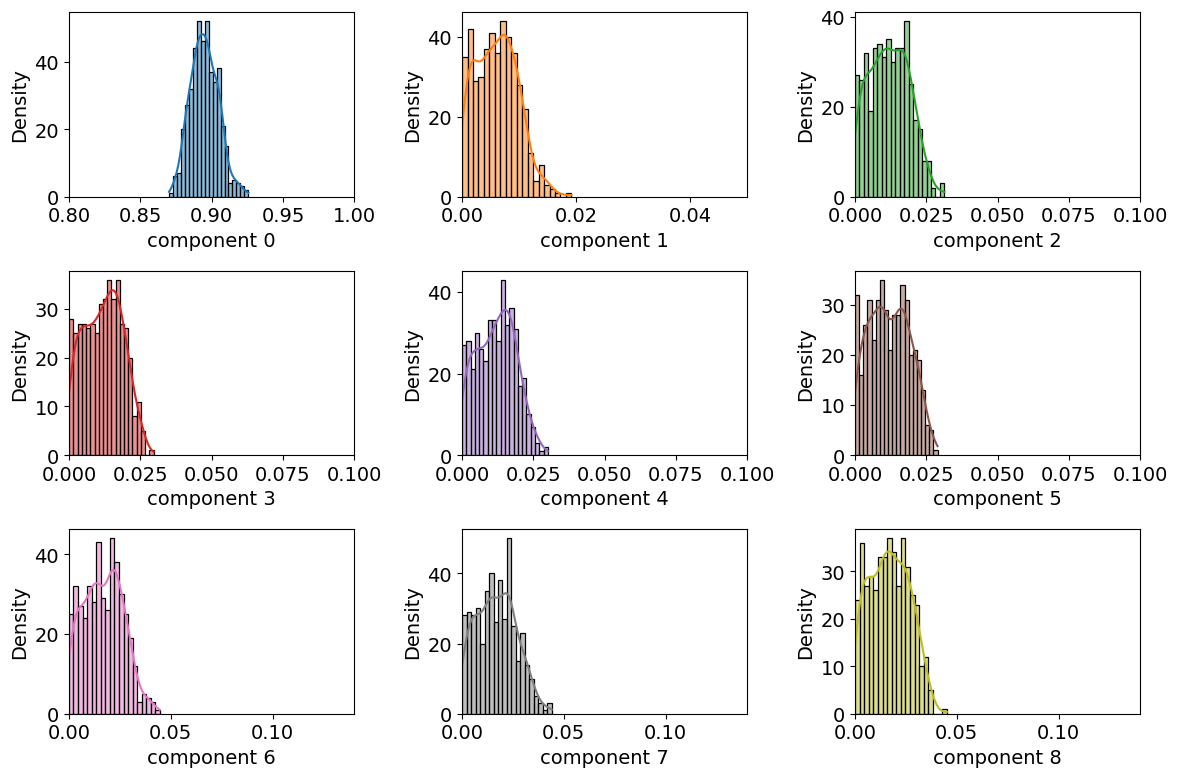

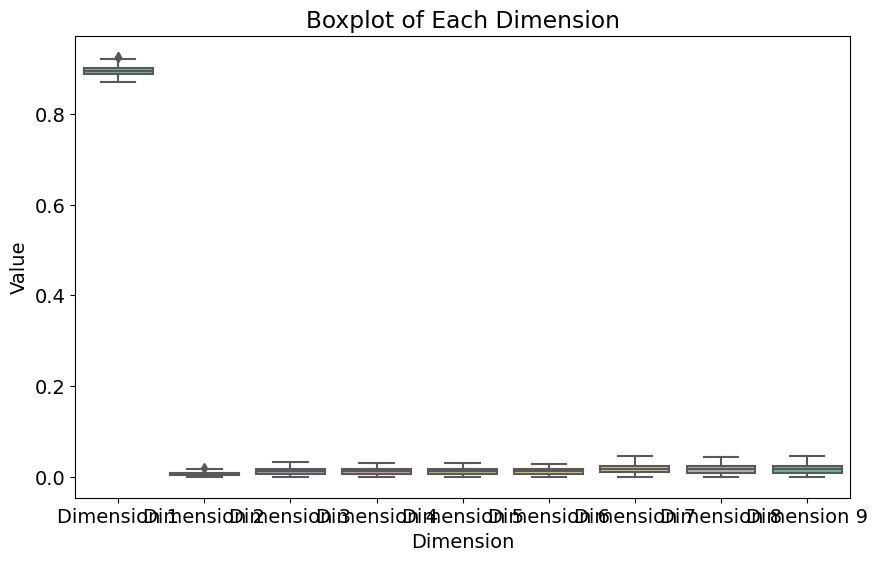

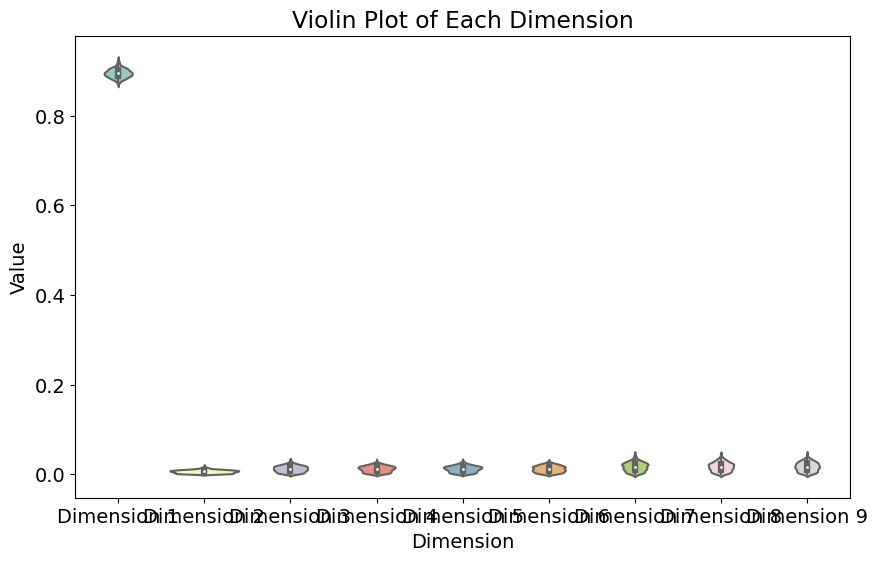

In [4]:
# Combine all samples into a single array (shape: num_seeds * n_samp, n_dim)
combined_samples = all_scaled_samples.reshape(-1, n_dim)

# Plot settings
#sns.set(style="whitegrid")
dim_labels = [f"Dimension {i+1}" for i in range(n_dim)]

# Plot 1: Histograms for each dimension
plt.figure(figsize=(12, 8))
for i in range(n_dim):
    ax = plt.subplot(3, 3, i + 1)
    sns.histplot(combined_samples[:, i], bins=20, kde=True, color=f"C{i}")
    #ax.set_title(f"Histogram of {dim_labels[i]}")
    ax.set_xlabel(f"component {i}")
    ax.set_ylabel("Density")
    if bounds is not None and i < len(bounds):
        ax.set_xlim(bounds[i])  # Correct way to set x-limits for each subplot
plt.tight_layout()
plt.show()


# Plot 2: Boxplot for each dimension
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_samples, palette="Set2")
plt.title("Boxplot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

# Plot 3: Violin Plot for Each Dimension
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_samples, palette="Set3")
plt.title("Violin Plot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

In [5]:
# Select most uniform samples
uniform_samples = select_most_uniform_samples(combined_samples, num_samples=90)
print(f"Shape of uniform samples: {uniform_samples.shape}")

Shape of uniform samples: (90, 9)


In [6]:
len(scaled_samples)
all_val_samples = uniform_samples

#### Latin Hypercube sampling with multidimensional uniformity on domain with variables summing up to 1: Sequentially and infeasible ones rejected/removed from sample set: 

In [7]:
# Define the number of samples and dimensions
n_samp = 90   # Number of samples
n_dim = 9     # Number of dimensions
seeds = [42, 123, 7, 99, 56]  # List of random seeds


# Function to normalize the samples
def normalize(samples):
    return samples / samples.sum(axis=1, keepdims=True)

# Function to scale the normalized samples while maintaining the sum constraint
def scale_and_renormalize(samples, bounds):
    scaled_samples = np.zeros_like(samples)
    for i, (lb, ub) in enumerate(bounds):
        scaled_samples[:, i] = lb + samples[:, i] * (ub - lb)
    # After scaling, renormalize to ensure the sum is exactly 1
    return scaled_samples / scaled_samples.sum(axis=1, keepdims=True)

# List to store the scaled samples from each seed
all_scaled_samples = []

# Generate samples for each seed
for seed in seeds:
    # Step 1: Generate Latin Hypercube samples using lhsmdu with the current seed
    lhs_samples = lhsmdu.sample(n_dim, n_samp, randomSeed=seed)
    
    # Convert to NumPy array and transpose to get shape (n_samp, n_dim)
    lhs_samples = np.array(lhs_samples).T

    # Step 2: Normalize the samples
    samples_normalized = normalize(lhs_samples)

    # Step 3: Scale and renormalize the samples
    scaled_samples = scale_and_renormalize(samples_normalized, bounds)

    # Store the scaled samples
    all_scaled_samples.append(scaled_samples)

# Stack all the samples along a new axis (shape: num_seeds x n_samp x n_dim)
all_scaled_samples = np.stack(all_scaled_samples, axis=0)

# Compute the mean and standard deviation across the seeds (axis=0)
mean_samples = np.mean(all_scaled_samples, axis=0)
std_samples = np.std(all_scaled_samples, axis=0)

# Verify the shapes of the results
print(f"\nShape of mean samples: {mean_samples.shape}")
print(f"Shape of std samples: {std_samples.shape}")

# Print the mean and standard deviation of the first 5 samples
print("\nMean of the first 5 samples:")
print(mean_samples[:5])

print("\nStandard deviation of the first 5 samples:")
print(std_samples[:5])



Shape of mean samples: (90, 9)
Shape of std samples: (90, 9)

Mean of the first 5 samples:
[[0.88893571 0.00681901 0.00953307 0.01227939 0.01040365 0.0124426
  0.01637973 0.02206358 0.02114326]
 [0.88701993 0.00551134 0.01553283 0.01292869 0.00926352 0.0081358
  0.02434934 0.01601774 0.02124082]
 [0.88425967 0.00514042 0.0181901  0.01513111 0.00516717 0.01019586
  0.02140908 0.01998314 0.02052345]
 [0.88818725 0.00475701 0.00894697 0.01855066 0.01431359 0.01276293
  0.01841553 0.01661026 0.01745579]
 [0.89787034 0.00521702 0.01325574 0.01375483 0.01522128 0.01123566
  0.01894431 0.0111565  0.01334432]]

Standard deviation of the first 5 samples:
[[0.00490381 0.00392746 0.00590196 0.00608071 0.00885341 0.00628689
  0.00468185 0.00960082 0.00728712]
 [0.00860426 0.00223271 0.00599795 0.00366128 0.00594527 0.00636959
  0.01239624 0.01155406 0.01715928]
 [0.0064884  0.00394126 0.01220414 0.00377523 0.00372631 0.00681147
  0.01440444 0.01023831 0.01479435]
 [0.00668155 0.0026834  0.0075774

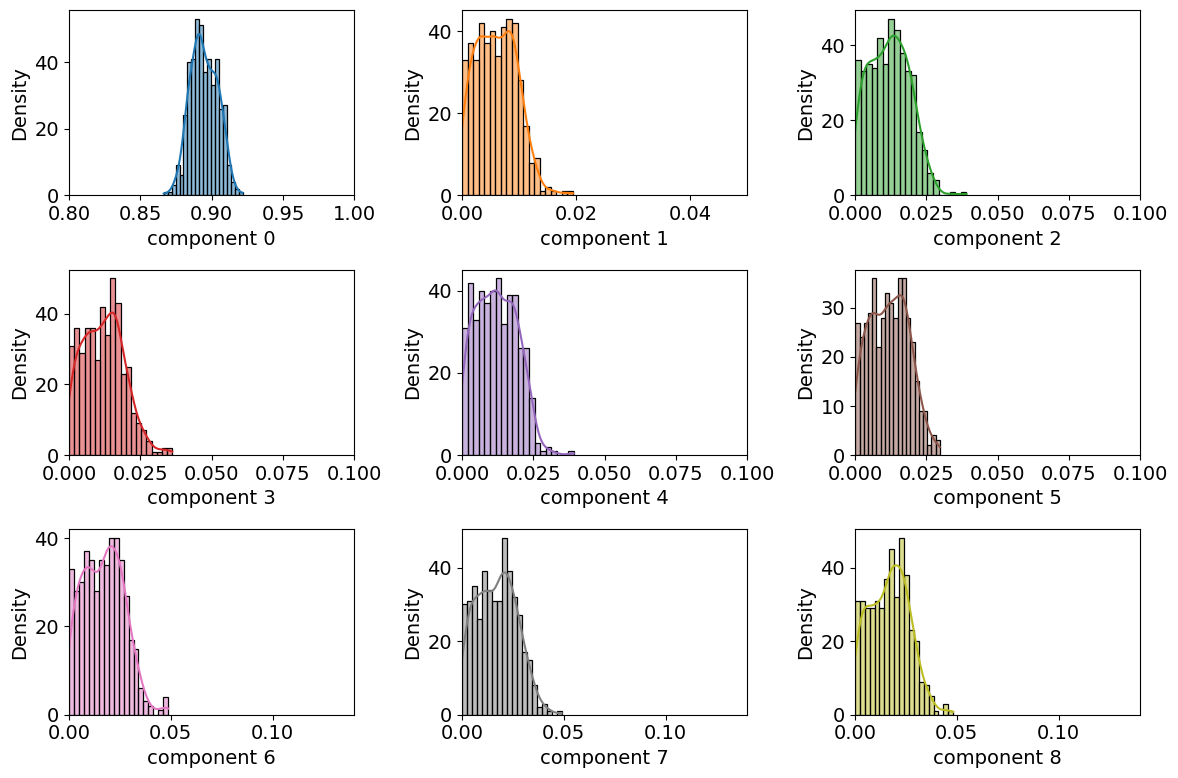

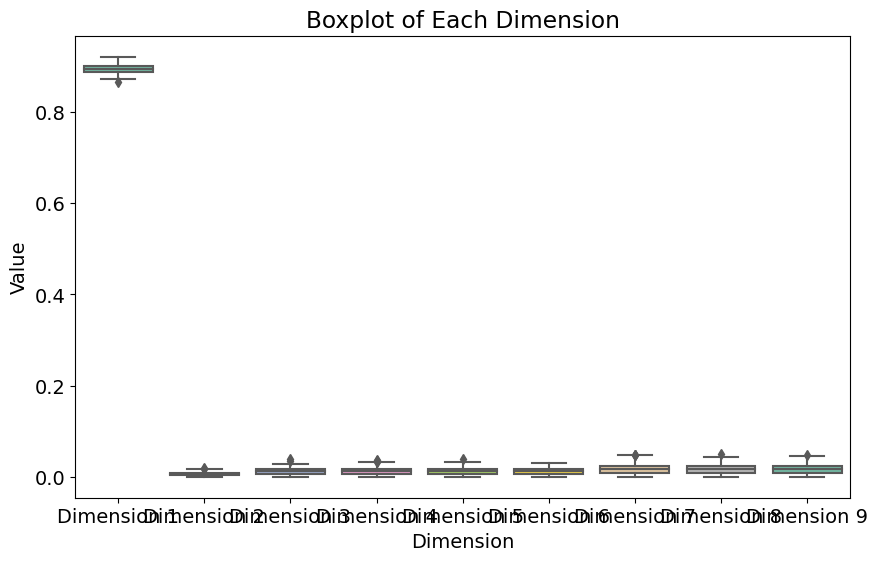

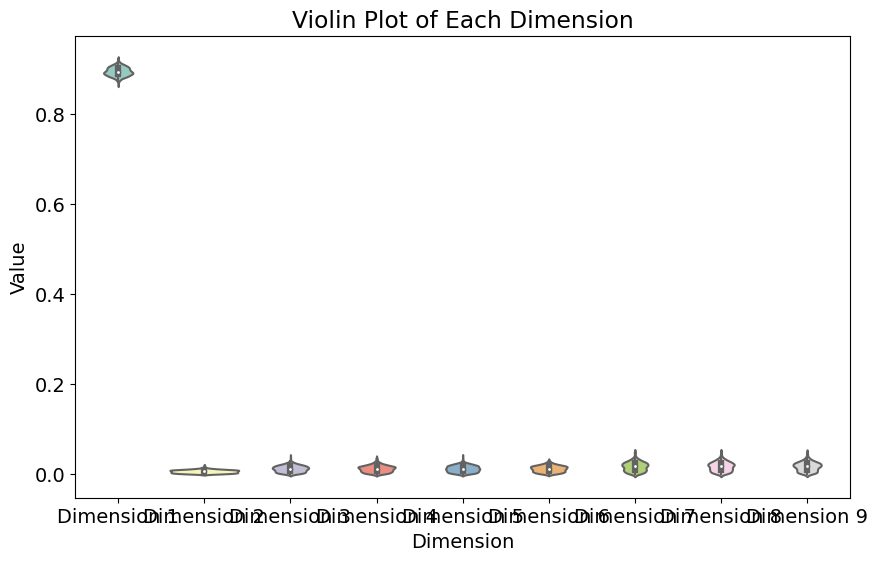

In [8]:
# Combine all samples into a single array (shape: num_seeds * n_samp, n_dim)
combined_samples = all_scaled_samples.reshape(-1, n_dim)

# Plot settings
#sns.set(style="whitegrid")
dim_labels = [f"Dimension {i+1}" for i in range(n_dim)]

# Plot 1: Histograms for each dimension
plt.figure(figsize=(12, 8))
for i in range(n_dim):
    ax = plt.subplot(3, 3, i + 1)
    sns.histplot(combined_samples[:, i], bins=20, kde=True, color=f"C{i}")
    #ax.set_title(f"Histogram of {dim_labels[i]}")
    ax.set_xlabel(f"component {i}")
    ax.set_ylabel("Density")
    if bounds is not None and i < len(bounds):
        ax.set_xlim(bounds[i])  # Correct way to set x-limits for each subplot
plt.tight_layout()
plt.show()


# Plot 2: Boxplot for each dimension
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_samples, palette="Set2")
plt.title("Boxplot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

# Plot 3: Violin Plot for Each Dimension
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_samples, palette="Set3")
plt.title("Violin Plot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

In [9]:
uniform_samples2 = select_most_uniform_samples(combined_samples, num_samples=90)
print(f"Shape of uniform samples: {uniform_samples2.shape}")

Shape of uniform samples: (90, 9)


In [10]:
all_val_samples_mdu = uniform_samples2

### Import data and format

In [11]:
filename = '../../../CASTRO/examples/data/Bank_Data-2808_mod_corrected.csv'
df = pd.read_csv(filename, sep=';', decimal=",")
#df = df.replace(',','.', regex=True)
df = df.div(100.)
data_array = np.zeros((len(df),8))
data_array = np.column_stack((df['PA-56'].to_numpy(), df['PhA'], df['Mel'], df['THAM'], df['CS'], df['BN'], df['ZnBO'], df['CaBO'], df['HNT']))


#### Standardize data

In [12]:
scaler = StandardScaler().fit(data_array)
data_scaled = scaler.transform(data_array)
scaler2 = StandardScaler().fit(all_val_samples)
all_val_samples_scaled = scaler2.transform(all_val_samples)
scaler3 = StandardScaler().fit(all_val_samples_mdu)
all_val_samples_mdu_scaled = scaler3.transform(all_val_samples_mdu)

### Transform with PCA and plot first two dimensions which are the most informative ones, for both LHS samples and Data

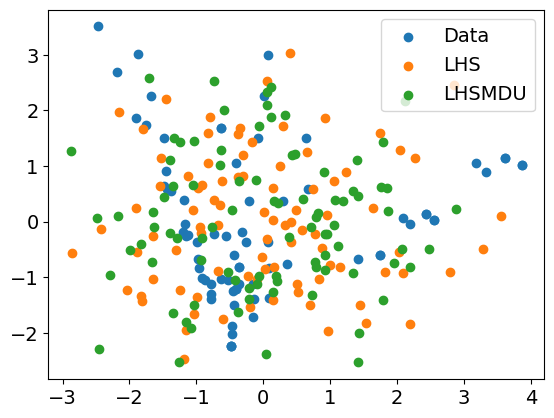

In [13]:
pca = PCA()
Xt1 = pca.fit_transform(data_scaled)
Xt2 = pca.fit_transform(all_val_samples_scaled)
Xt3 = pca.fit_transform(all_val_samples_mdu_scaled)
plt.scatter(Xt1[:,0], Xt1[:,1])
#plt.legend(handles=plot.legend_elements()[0])#, labels=['PA56', 'PhA', 'am-based', 'met-based'])
plt.scatter(Xt2[:,0], Xt2[:,1])
plt.scatter(Xt3[:,0], Xt3[:,1])
plt.legend(['Data', 'LHS', 'LHSMDU'])
plt.show()



In [14]:
#print(len(Xt1))
for i in range(len(Xt2)):
    if (Xt2[i,1]>-0.06 and Xt2[i,1]<-0.04 and Xt2[i,0]< -0.1):
        print(Xt2[i,0],Xt2[i,1],Xt2[i,:],i)
        print('orig',all_val_samples[i,:])

### Transform with PCA and plot first two dimensions which are the most informative ones, for both LHS samples and Data

#### Select subset of samples that varies the most in terms of distance from the already collected data

In [15]:
tol = 1e-5
tol2 = 1e-5
des_n_samp = 15

tol_samples, tol_samples_LHSMDU, tol_samples_unscaled, tol_samples_LHSMDU_unscaled = select_samples_diff_from_data(exp_data=data_array, samples_LHS=all_val_samples, samples_LHSMDU=all_val_samples_mdu, des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


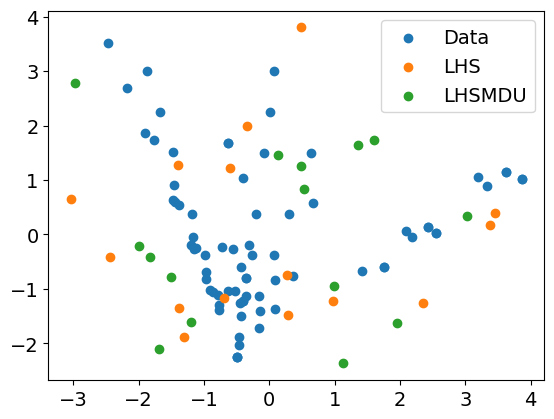

In [16]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
lhs_samples_pca = pca.fit_transform(tol_samples)
lhsmdu_samples_pca = pca.fit_transform(tol_samples_LHSMDU)

plot_dimred_2dims_both_methods(data_pca, lhs_samples_pca, lhsmdu_samples_pca)

#### Test whether all selected samples are feasible

In [17]:
for i in range(len(tol_samples_unscaled)):
    for j in range(dim):
        if tol_samples_unscaled[i,j]<bounds[j][0] or tol_samples_unscaled[i,j]>bounds[j][1]:
            print("not feasible", tol_samples_unscaled[i,:])
print("-------------------")
for i in range(len(tol_samples_LHSMDU_unscaled)):
    for j in range(dim):
        if tol_samples_LHSMDU_unscaled[i,j]<bounds[j][0] or tol_samples_LHSMDU_unscaled[i,j]>bounds[j][1]:
            print("not feasible", tol_samples_LHSMDU_unscaled[i,:])

-------------------


In [18]:
df_15_samps_scaled = pd.DataFrame(tol_samples,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps = pd.DataFrame(tol_samples_unscaled,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

#### Check if add up to 100%

In [19]:
df_perc = df_15_samps*100
for i in range(len(df_15_samps)):
    if abs(df_15_samps.iloc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_15_samps.iloc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_15_samps.iloc[i,ind] = df_15_samps.iloc[i,ind] - (df_15_samps.iloc[i,:].sum()-1)

In [20]:
df_15_samps

,PA-56,PhA,Mel,THAM,CS,BN,ZnBO,CaBO,HNT
0,0.880,0.002,0.008,0.023,0.013,0.023,0.005,0.013,0.033
1,0.894,0.000,0.027,0.009,0.018,0.002,0.008,0.038,0.004
2,0.926,0.014,0.010,0.004,0.005,0.005,0.001,0.031,0.004
3,0.875,0.000,0.018,0.015,0.004,0.016,0.036,0.022,0.014
4,0.890,0.009,0.012,0.003,0.024,0.025,0.030,0.002,0.005
5,0.874,0.002,0.006,0.006,0.015,0.021,0.016,0.034,0.026
6,0.909,0.000,0.025,0.004,0.026,0.012,0.001,0.023,0.000
7,0.890,0.004,0.024,0.003,0.006,0.026,0.012,0.034,0.001
8,0.902,0.003,0.020,0.020,0.000,0.021,0.030,0.002,0.002
9,0.887,0.003,0.026,0.025,0.015,0.020,0.003,0.000,0.021


### **7. Distribution plots**

#### Distribution subplots of unscaled data: first 90 pts, then 15 pts

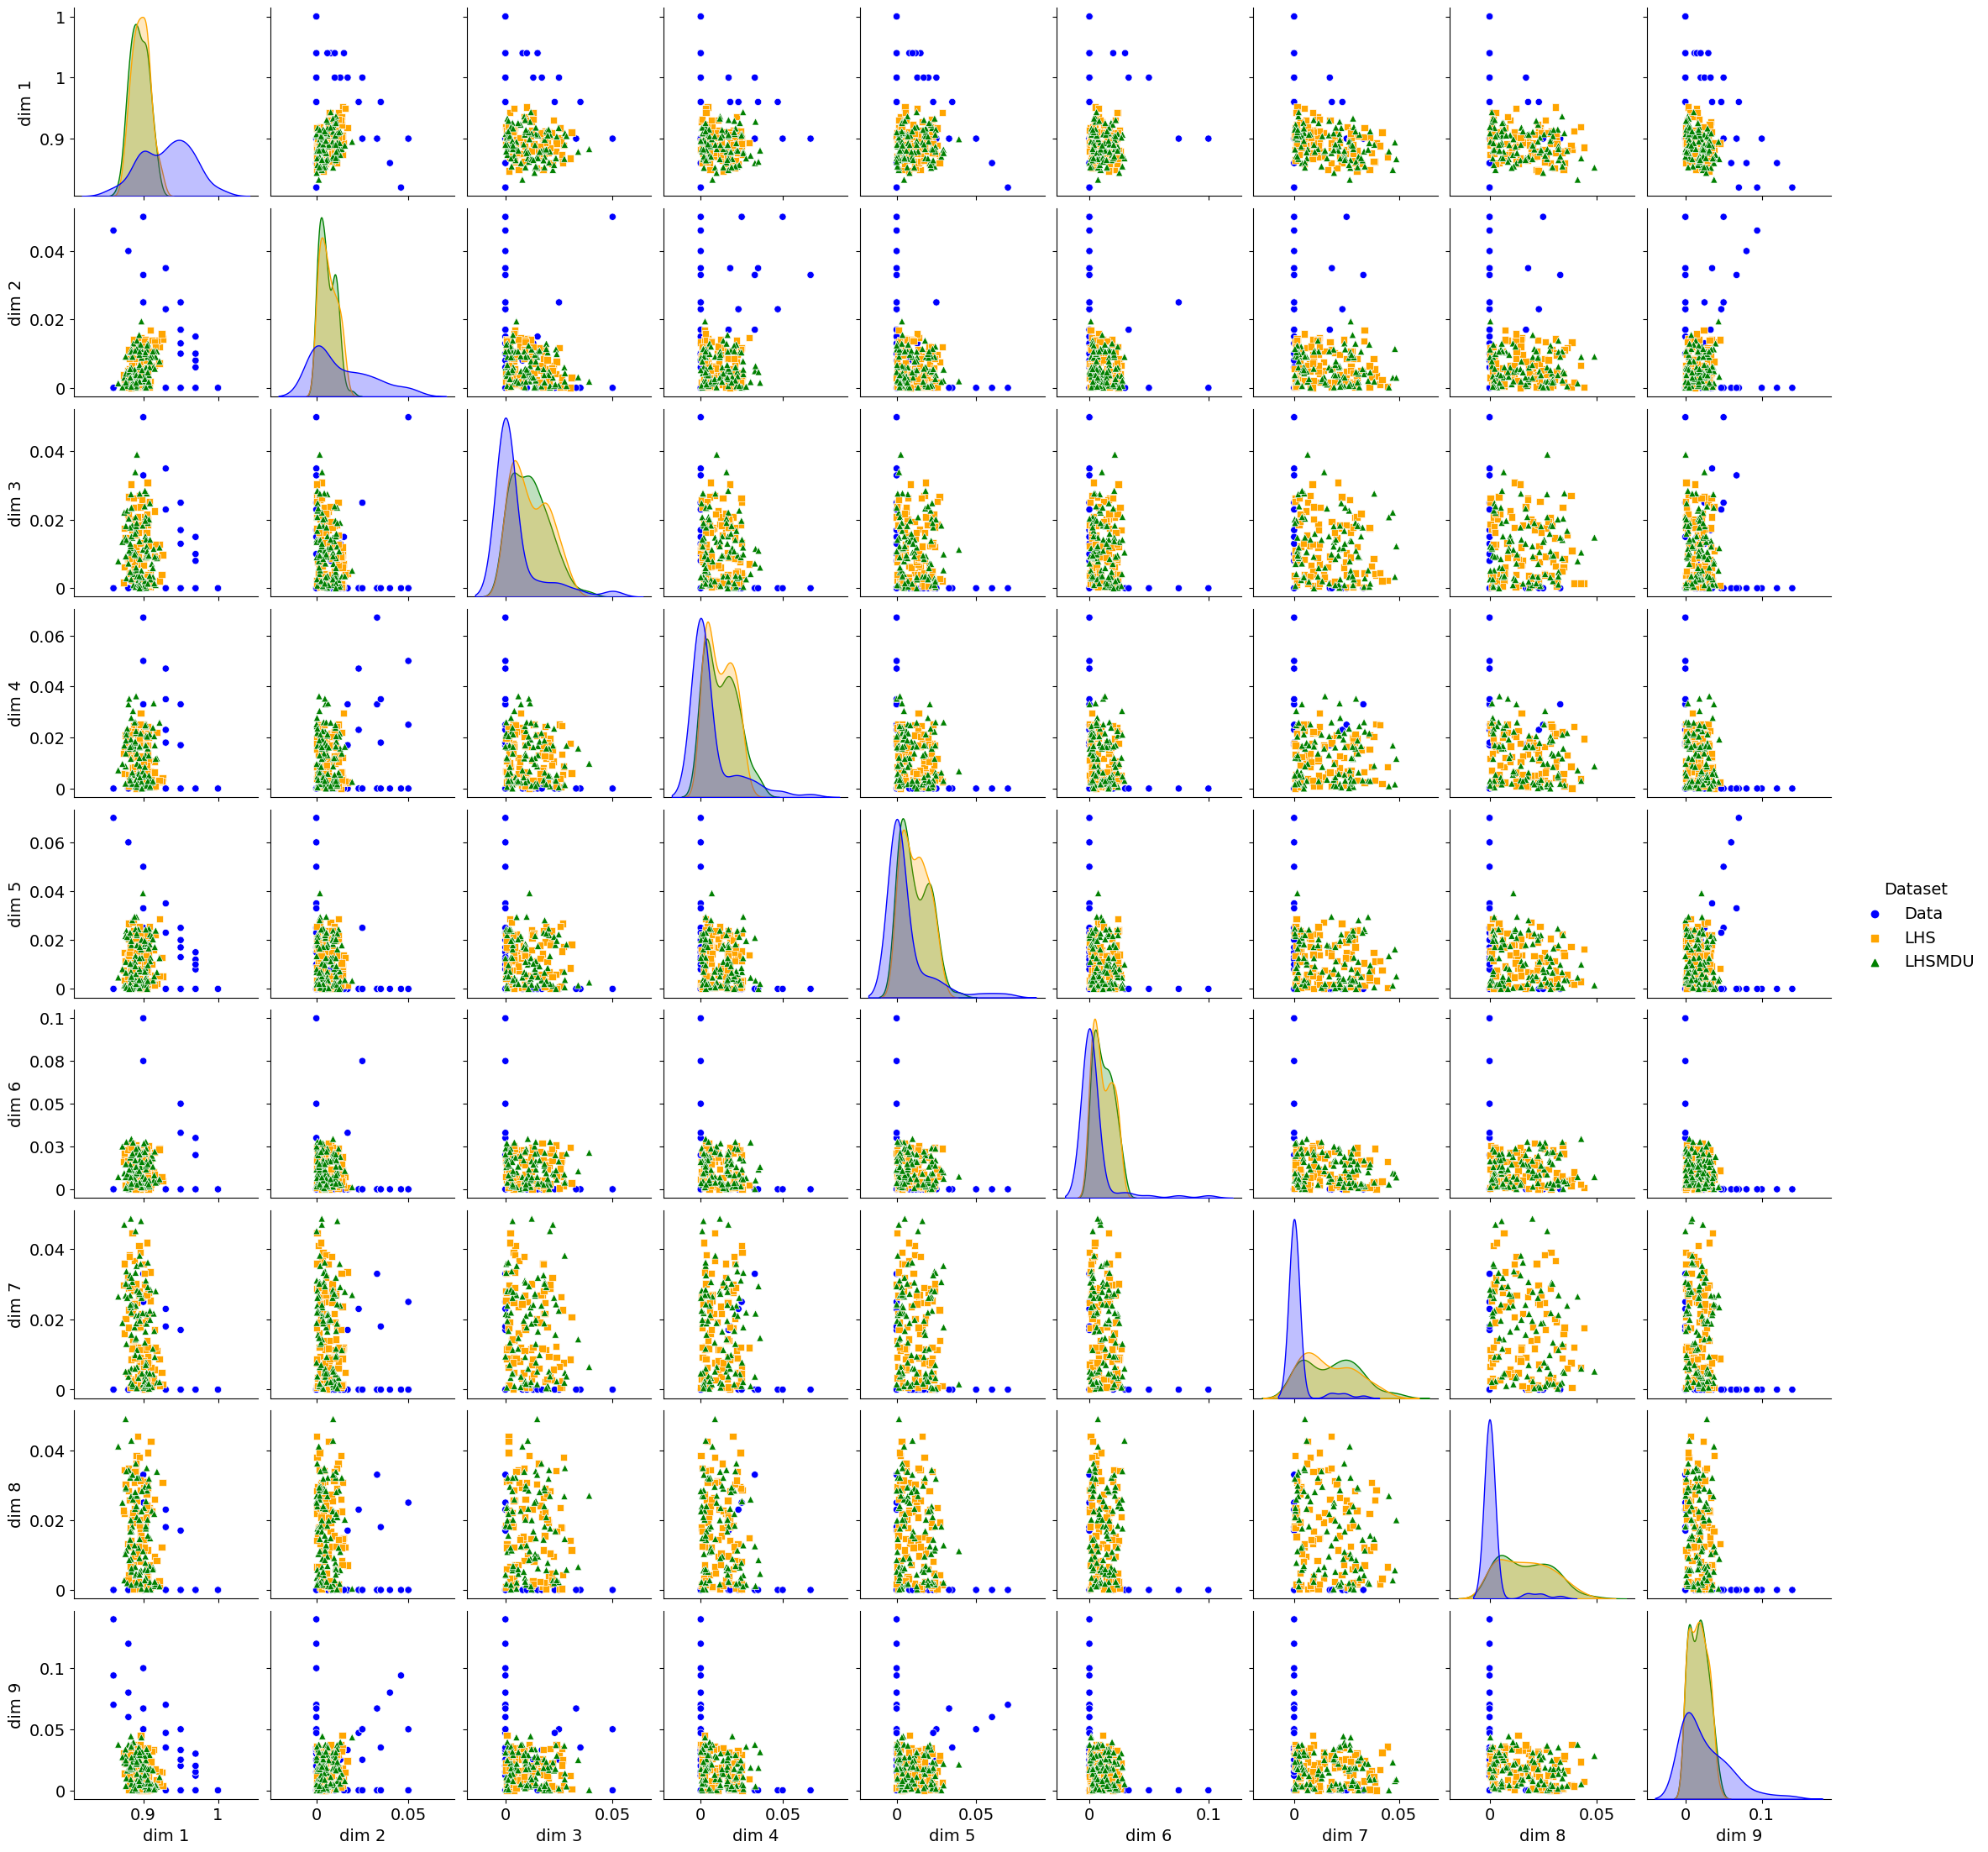

In [21]:
l_bounds = [0.8, 0, 0, 0, 0, 0, 0 , 0 , 0]
u_bounds = [1., 0.05, 0.1, 0.1 , 0.1, 0.1, 0.14, 0.14, 0.14]
bounds = [[lb, ub] for lb, ub in zip(l_bounds, u_bounds)]
create_pairwise_distribution_plots_seaborn(data_array, all_val_samples, all_val_samples_mdu, markers=["o", "s", "^"], filename_eps="pairwise_distributionsLHS_LHSMDU_90pts_9dim.png")

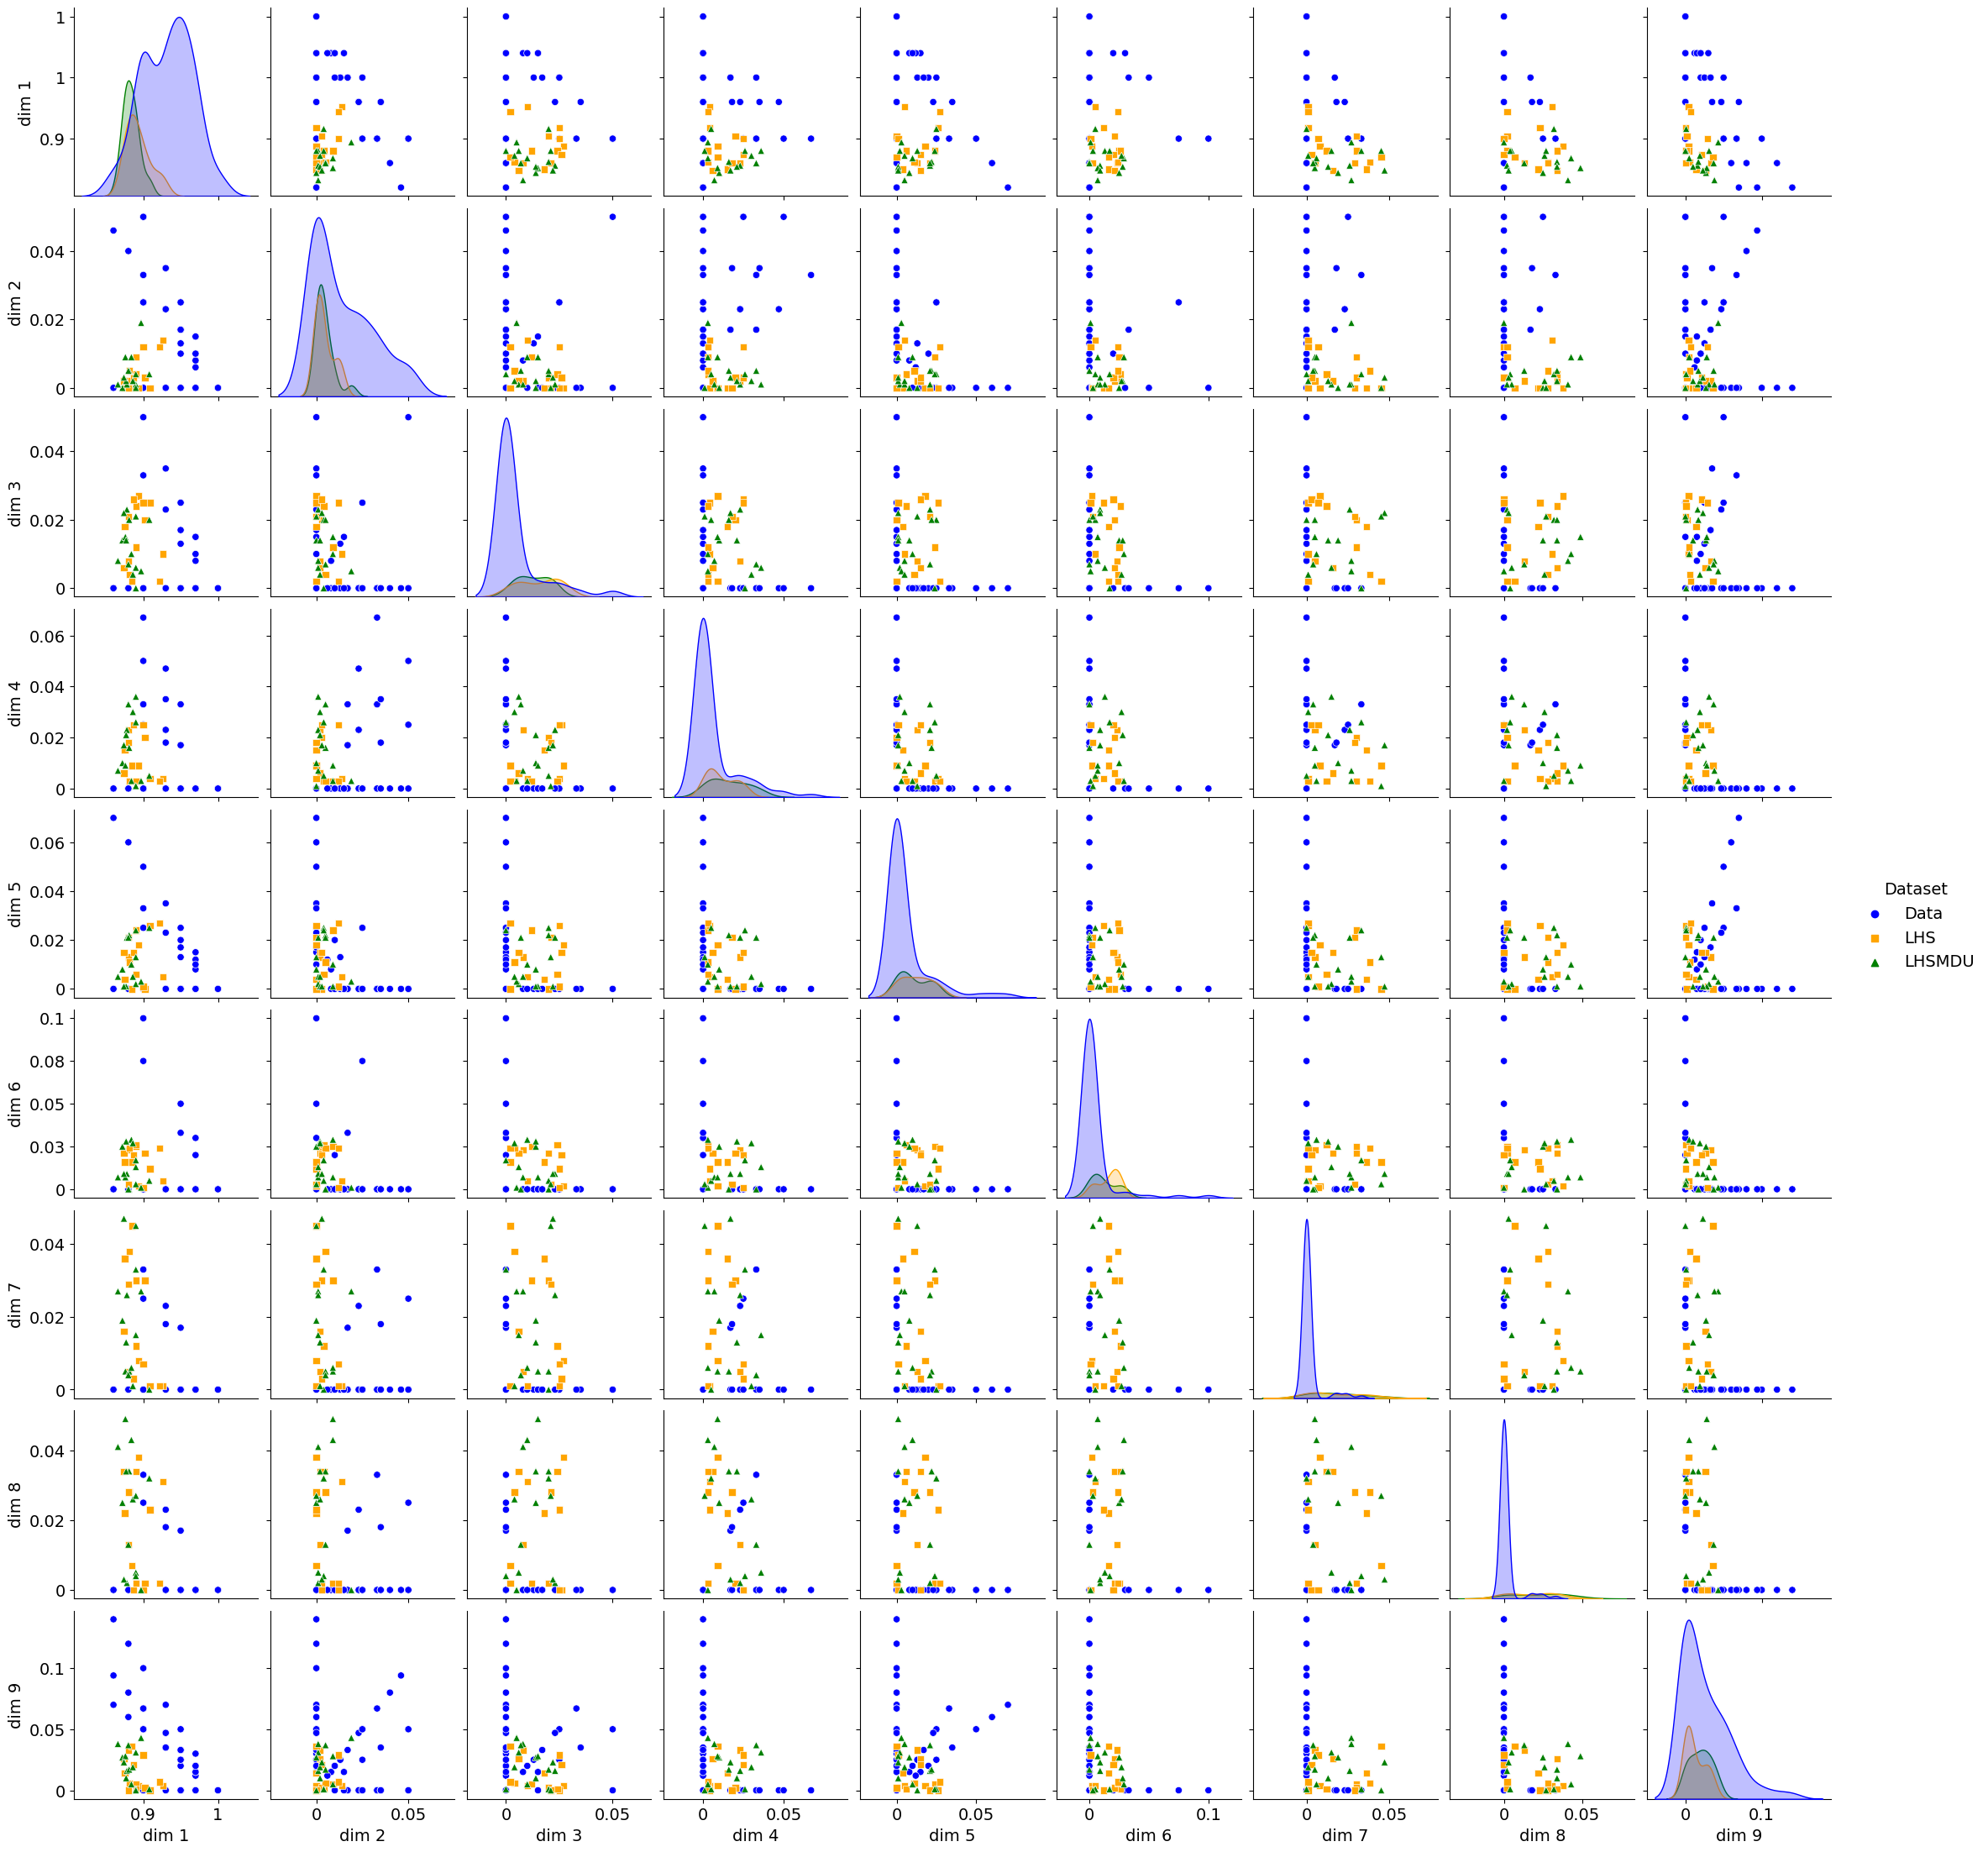

In [22]:
create_pairwise_distribution_plots_seaborn(data_array, tol_samples_unscaled, tol_samples_LHSMDU_unscaled, markers=["o", "s", "^"], filename_eps="pairwise_distributionsLHS_LHSMDU_15pts_9dim.png")

### **8. Discrepancy for LHS and LHSMDU with mixture constraint sum=1**

In [23]:
space = qmc.scale(all_val_samples, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

7.224649826033799

In [24]:
qmc.discrepancy(space, method='WD')


10.251077463772534

In [25]:
np.linalg.norm(space.var())

0.01986342456548437

In [26]:
space = qmc.scale(all_val_samples_mdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

7.070966562906425

In [27]:
qmc.discrepancy(space, method='WD')

9.976733482896366

In [28]:
np.linalg.norm(space.var())

0.019483894064076603

In [29]:
tol_samples_unscaled

array([[0.88 , 0.002, 0.008, 0.023, 0.013, 0.023, 0.005, 0.013, 0.033],
       [0.894, 0.   , 0.027, 0.009, 0.018, 0.002, 0.008, 0.038, 0.004],
       [0.926, 0.014, 0.01 , 0.004, 0.005, 0.005, 0.001, 0.031, 0.004],
       [0.875, 0.   , 0.018, 0.015, 0.004, 0.016, 0.036, 0.022, 0.014],
       [0.89 , 0.009, 0.012, 0.003, 0.024, 0.025, 0.03 , 0.002, 0.005],
       [0.874, 0.002, 0.006, 0.006, 0.015, 0.021, 0.016, 0.034, 0.026],
       [0.909, 0.   , 0.025, 0.004, 0.026, 0.012, 0.001, 0.023, 0.   ],
       [0.89 , 0.004, 0.024, 0.003, 0.006, 0.026, 0.012, 0.034, 0.001],
       [0.902, 0.003, 0.02 , 0.02 , 0.   , 0.021, 0.03 , 0.002, 0.002],
       [0.887, 0.003, 0.026, 0.025, 0.015, 0.02 , 0.003, 0.   , 0.021],
       [0.9  , 0.012, 0.025, 0.025, 0.001, 0.001, 0.007, 0.   , 0.029],
       [0.881, 0.005, 0.004, 0.003, 0.011, 0.024, 0.038, 0.028, 0.006],
       [0.885, 0.   , 0.002, 0.009, 0.   , 0.016, 0.045, 0.007, 0.036],
       [0.88 , 0.   , 0.021, 0.018, 0.021, 0.003, 0.029, 0.028, 

In [30]:
space = qmc.scale(df_15_samps, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

6.983154504210839

In [31]:
qmc.discrepancy(space, method='WD')

9.769146318389678

In [32]:
np.linalg.norm(space.var())

0.020540678760393043

In [33]:
df_data = df[['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT']].copy()
df_data = df_data
df_with_data = pd.concat([df_15_samps, df_data], ignore_index=True, axis=0)

In [34]:
space = qmc.scale(df_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

9.545681453438807

In [35]:
qmc.discrepancy(space, method='WD')

9.641051054238128

In [36]:
np.linalg.norm(space.var())

0.060428235386747284

In [37]:
df_15_samps_mdu_scaled = pd.DataFrame(tol_samples_LHSMDU,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps_mdu = pd.DataFrame(tol_samples_LHSMDU_unscaled,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
space = qmc.scale(df_15_samps_mdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

6.639171013417539

In [38]:
qmc.discrepancy(space, method='WD')

9.567921108713454

In [39]:
np.linalg.norm(space.var())

0.01783381697040956

In [40]:
df_lhsmdu_with_data = pd.concat([df_15_samps_mdu, df_data], ignore_index=True, axis=0)

In [41]:
space = qmc.scale(df_lhsmdu_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

9.432620923871156

In [42]:
qmc.discrepancy(space, method='WD')

9.561122028632264

In [43]:
np.linalg.norm(space.var())

0.05997898614649334

#### Distribution subplots of unscaled data: 15pts plus data

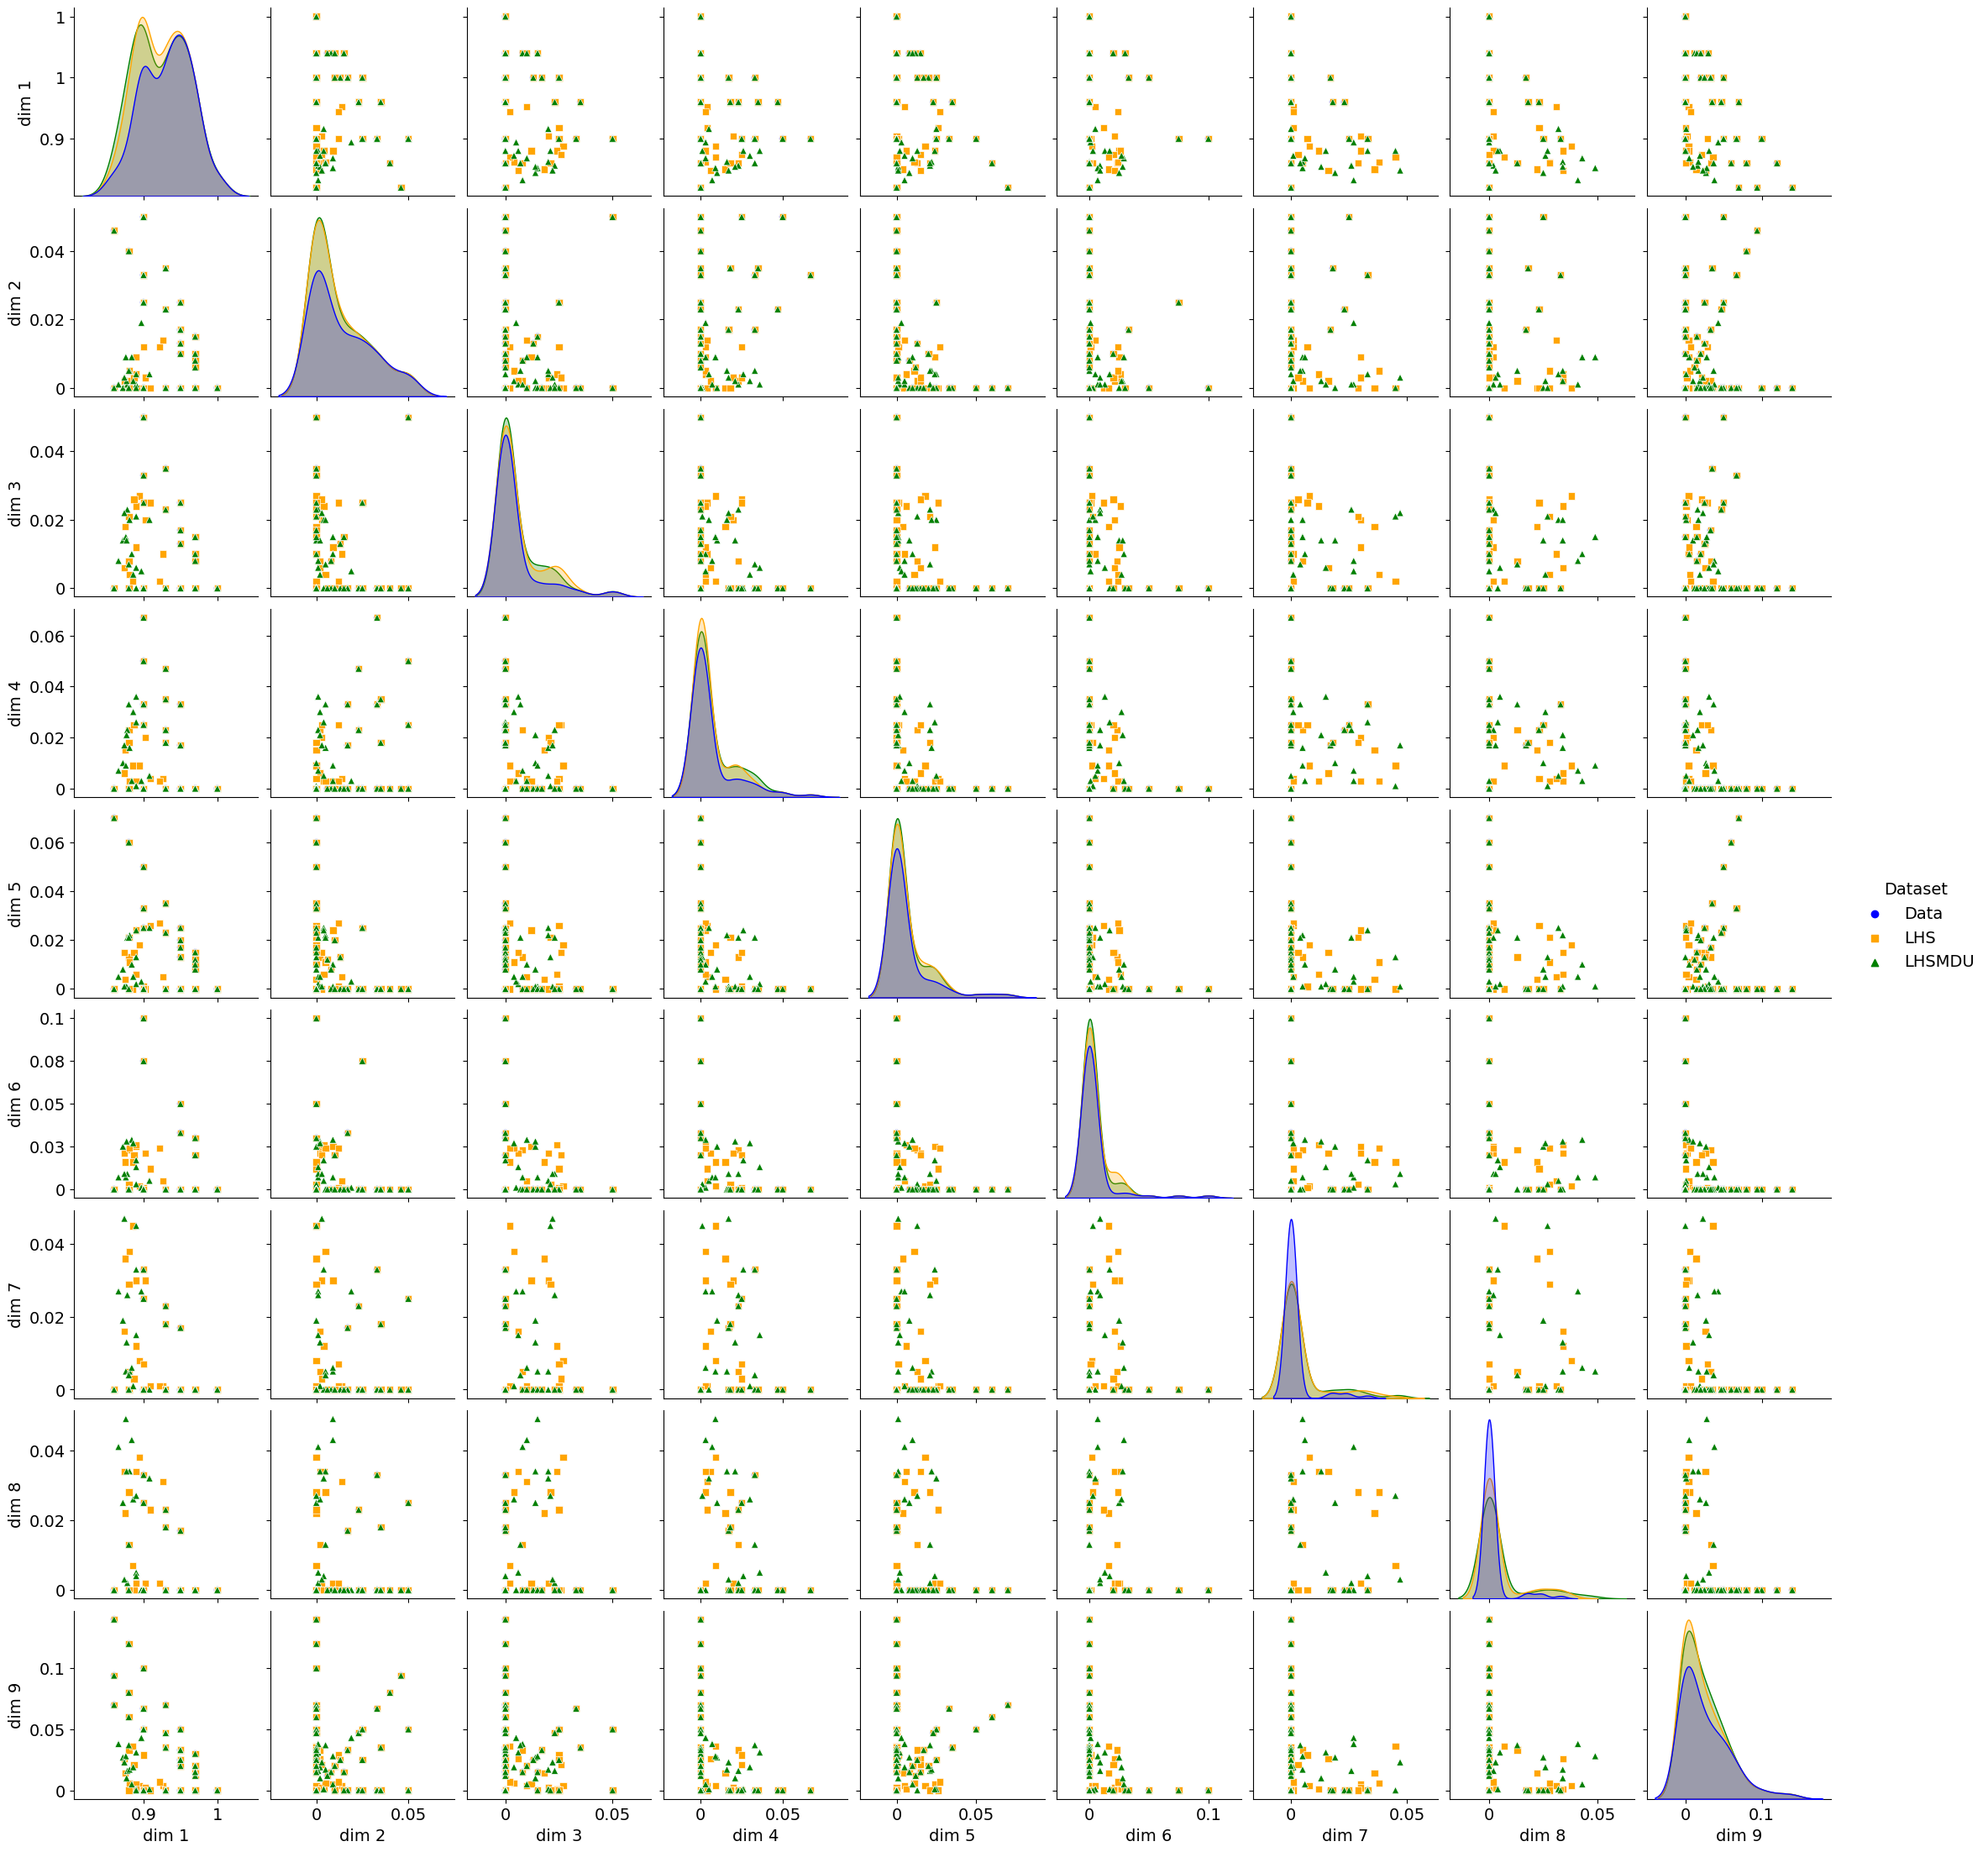

In [44]:
create_pairwise_distribution_plots_seaborn(data_array, np.array(df_with_data), np.array(df_lhsmdu_with_data), markers=["o", "s", "^"], filename_eps="pairwise_distributionsLHS_LHSMDU_15ptsplusdata_9dim.png")